# From the RBM to the Generalized Ising Model


## Introduction

Let us start from the energy function of a trained Restricted Boltzmann Machine (RBM):

$$
 \mathcal{H}(\boldsymbol{v}, \boldsymbol{h}) = - \sum_{i=1}^{N_h} c_i h_i  - \sum_{j=1}^{N_v} b_j v_j - \sum_{j=1}^{N_v} \sum_{i=1}^{N_h}  h_i W_{ij} v_j , \tag{1}
$$

with binary variables $v_j, h_i \in \{0, 1 \}$. By applying a change of variables and then marginalizing over the hidden nodes, one can obtain an expression for the energy solely dependent upon the visible nodes $s_j \in \{ -1, 1 \}$:

$$
\begin{align}
\mathcal{H}(\boldsymbol{\sigma}) 
&= - \sum_j \left( b_j + \frac{1}{2} \sum_i W_{ij} \right) \sigma_j - \sum_i \ln \cosh \left[ \frac{1}{4} \sum_j W_{ij} \sigma_j + \frac{1}{2} \left( c_i + \frac{1}{2} \sum_j W_{ij} \right) \right] \\ 
&= - \sum_j \eta_j \sigma_j - \sum_i \ln \cosh \left( \sum_j w_{ij} \sigma_j + \theta_i \right), \tag{2}
\end{align}
$$

where the following variables were defined

$$
\eta_j \equiv \frac{1}{2} \left( b_j + \frac{1}{2} \sum_i W_{ij} \right), \ \theta_i \equiv \frac{1}{2} \left( c_i + \frac{1}{2} \sum_j W_{ij} \right), \ w_{ij} \equiv \frac{1}{4} W_{ij}. \tag{3}
$$

It can be we showed that the effective Hamiltonian given in the Eq. $(2)$ can be expanded as a generalized Ising Hamiltonian of the form
 
$$ \begin{align} 
\mathcal{H}_{\mathrm{GIM}}(\boldsymbol{\sigma}) 
&= - \sum_j H_j \sigma_j - \sum_{j_1 > j_2} J^{(2)}_{j_1 j_2} \sigma_{j_1} \sigma_{j_2} - \sum_{j_1 > j_2 > j_3} J_{j_1 j_2 j_3}^{(3)} \sigma_{j_1} \sigma_{j_2} \sigma_{j_3} + \dots \nonumber + \sum_{j_1 > \cdots > j_k} J^{(n)}_{j_1,\ldots,j_n}\sigma_{j_1} \cdots \sigma_{j_n} + \dots,
\tag{4}
\end{align}$$
 
The exact derivation of the mapping beetween the RBM parameters $\eta_j, \theta_i, w_{ij}$ and the couplings $H_{j_1 \dots j_n}$ is provided in [1]. Here, we will numerically implement the expressions provided in [1].

In [1]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import h5py

# numerical methods
from scipy.stats import norm
from scipy.integrate import simps

In [2]:
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Loading the parameters of a saved RBM training

First, we need the parameters of an RBM trained with samples from the Ising model. Since this notebook will be exclusively dedicated to the numerical implementation of the mapping provided in [1], we will not delve into the generation of Ising model samples or the training of the models, which are described in a general manner also in [1].

In this context, we already have machines that have been trained with configurations of the the Ising model, which will serve as examples for introducing our methods. The files containing the parameters of these machines can be found in this repository in `./model/(...)`.

In this case, we will use a model that was trained with samples of a 2D disordered Ising model (i.e., a Edwards-Anderson model) with $\beta = 0.2$ and $L=7$. 

In [3]:
# For this first example let us use a machine that was trained with

# reading the file
f = h5py.File(f'./models/2D_EAmodel_β=0.2_L=7_M=10000_PCD-50_Nh=100_lr=0.1.h5','r')

# setting the epoch we are going to look at
ep = 5000

# Initialize the variables
W = np.array(f['W'+str(ep)]) # dim: Nh x Nv
b = np.array(f['vbias'+str(ep)]) # dim: Nv
c = np.array(f['hbias'+str(ep)]) # dim: Nh

# change of variables
w = 0.25*W # dim: Nh x Nv
η = 0.5*b + w.sum(axis = 0) # dim: Nv
θ = 0.5*c +  w.sum(axis = 1) # dim: Nh

# closing the chanel file
f.close()

## Extracting field couplings

The mapping for the external field terms $H_j$ are given by 

$$
H_j = \eta_j + \frac{1}{2} \sum_i \mathbb{E}_{X_1^{(j)}} \left[ \ln \frac{\cosh \left( \theta_i + w_{ij} + X_i^{\left( j_1 \right)} \right)}{\cosh \left( \theta_i -w_{ij} + X_i^{\left( j_1 \right)} \right)} \right],  \tag{5}
$$
where it is assumed that
$
X_i^{\left( j_1 \dots j_m \right)} \sim \mathcal{N} \left(0, \sum_{j \neq j_1 \dots j_m} w_{ij}^2 \right).
$


In [7]:
# Defining the functions

def arg_func1(x, i, j, w, θ):
    """
    A function to compute the argument of the average in the Eq. (5)
    """
    return np.log(np.cosh(θ[i] + w[i,j] + x ) 
                  / np.cosh(θ[i] - w[i,j] + x) 
                 )

def est_expect1(i, j, w, θ, α=15, Δx=0.1):
    """
    For a given index i, it computes the average in the Eq. (5) using the simpson's rule.
    
    params:
    - α: it sets the domain of the numerical integration to [-α, α]
    - Δx: the step size of the numerical integration
    """
    
    # setting the domain of the numerical integral
    n_steps = int(2*α*(1/Δx))
    x = np.linspace(-α, α, n_steps)
    
    # evaluating the arg function in the corresponding domain
    func = arg_func1(x, i, j, w, θ)

    # computing the gaussian that approximates the probability function
    w_mod = np.delete(w[i,:], j)
    sd = np.linalg.norm(w_mod)
    gauss = norm.pdf(x, loc=0, scale=sd)
    
    # returns the results of the numerical integration
    return simps(func*gauss, x)

def est_H1(j, w, θ, η):
    """
    Computes the r.h.s. of Eq. (5) 
    """
    H = 0
    Nh = θ.size 
    H = np.sum([est_expect1(i, j, w, θ) for i in range(Nh)], axis=0)
    return η[j] + 0.5*H

In [8]:
# extracting fields
fields = []
Nv = w.shape[1]
for j in range(Nv):
    H = est_H1(j, w, θ, η)
    fields.append(H)
fields = np.array(fields)

Mean: 0.015
Standard deviation: 0.055


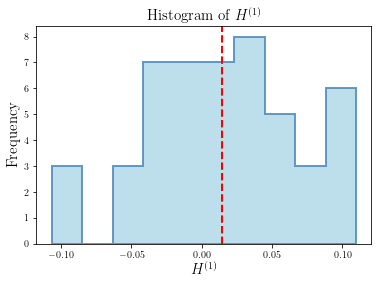

In [10]:
# Calculate the mean and standard deviation of the data
mean = np.mean(fields)
sd = np.std(fields)

# Create the histogram
plt.hist(fields, 
         bins=10, 
         histtype='stepfilled', 
         color='lightblue', 
         edgecolor='steelblue',
         linewidth=2,
         alpha=0.8)

# Add a vertical line to represent the mean
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)

# Labels and title of the plot
plt.ylabel('Frequency', fontsize=15)
plt.xlabel(r'$H^{(1)}$', fontsize=15)
plt.title('Histogram of $H^{(1)}$', fontsize=15)

# Display the mean and standard deviation
print('Mean:', mean.round(3))
print('Standard deviation:', sd.round(3))

# Show the plot
plt.show()

## Extracting 2-body couplings

Analogously, the expression for the 2-body couplings is given by

$$
J_{j_1 j_2}^{(2)} = \frac{1}{4} \sum_i \mathbb{E}_{X_i^{(j_1 j_2)}} \left[ \ln \frac{ \cosh \left( \theta_i + w_{i j_1} + w_{i j_2} + X_i^{\left( j_1 j_2 \right)} \right) \cosh \left( \theta_i - ( w_{i j_1} + w_{i j_2} ) + X_i^{\left( j_1 j_2 \right)} \right)}{ \cosh \left( \theta_i + (w_{i j_1} - w_{i j_2}) + X_i^{\left( j_1 j_2 \right)} \right) \cosh \left( \theta_i - ( w_{i j_1} - w_{i j_2} ) + X_i^{\left( j_1 j_2 \right)} \right) } \right], \tag{6}
$$

where
$
X_i^{\left( j_1 \dots j_m \right)} \sim \mathcal{N} \left(0, \sum_{\mu = 3}^{N_v} w_{ij_\mu}^2 \right).
$

In [42]:
# Defining the functions

def arg_func2(x, i, j1, j2, w, θ):
    """
    A function to compute the argument of the average in the Eq. (6)
    """
    return np.log(np.cosh(θ[i] + (w[i,j1]+w[i,j2]) + x)*np.cosh(θ[i] - (w[i,j1]+w[i,j2]) + x) 
                  / np.cosh(θ[i] + (w[i,j1]-w[i,j2]) + x)*np.cosh(θ[i] - (w[i,j1]-w[i,j2]) + x) 
                 )

def est_expect2(i, j1, j2, w, θ, α=15, Δx=0.1):
    """
    For a given index i, it computes the average in the Eq. (6) using the simpson's rule.
    
    params:
    - α: it sets the domain of the numerical integration to [-α, α]
    - Δx: the step size of the numerical integration
    """
    
    # setting the domain of the numerical integral
    n_steps = int(2*α*(1/Δx))
    x = np.linspace(-α, α, n_steps)
    
    # evaluating the arg function in the corresponding domain
    func = arg_func2(x, i, j1, j2, w, θ)

    # computing the gaussian that approximates the probability function
    w_mod = np.delete(w[i,:], [j1, j2])
    sd = np.linalg.norm(w_mod)
    gauss = norm.pdf(x, loc=0, scale=sd)
    
    # returns the results of the numerical integration
    return simps(func*gauss, x)

def est_J2(j1, j2, w, θ):
    """
    Computes the r.h.s. of Eq. (6) 
    """
    J = 0
    Nh = θ.size 
    for i in range(Nh):
        J += est_expect2(i, j1, j2, w, θ)
    return η[j] + 0.5*H

In [44]:
# Extracting couplings (2nd order)
Nv = w.shape[1]
couplings = np.zeros((Nv, Nv))
for j1 in range(1, Nv):
    for j2 in range(j1):
        couplings[j1, j2] = est_J2(j1, j2, w, θ)

# This cell runs in ~20s

## Reference

[1] Decelle, A., Furtlehner, C., Navas Gómez, A. J., & Seoane, B. (2023). Inferring effective couplings with Restricted Boltzmann Machines. arXiv preprint arXiv:2309.02292.